## **IMPORT DATASET**

In [1]:
import pandas as pd
import missingno as msno

data = pd.read_csv("taxi_fare.csv", parse_dates=["pickup_datetime"])
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


## **MISSING VALUES**

<Axes: >

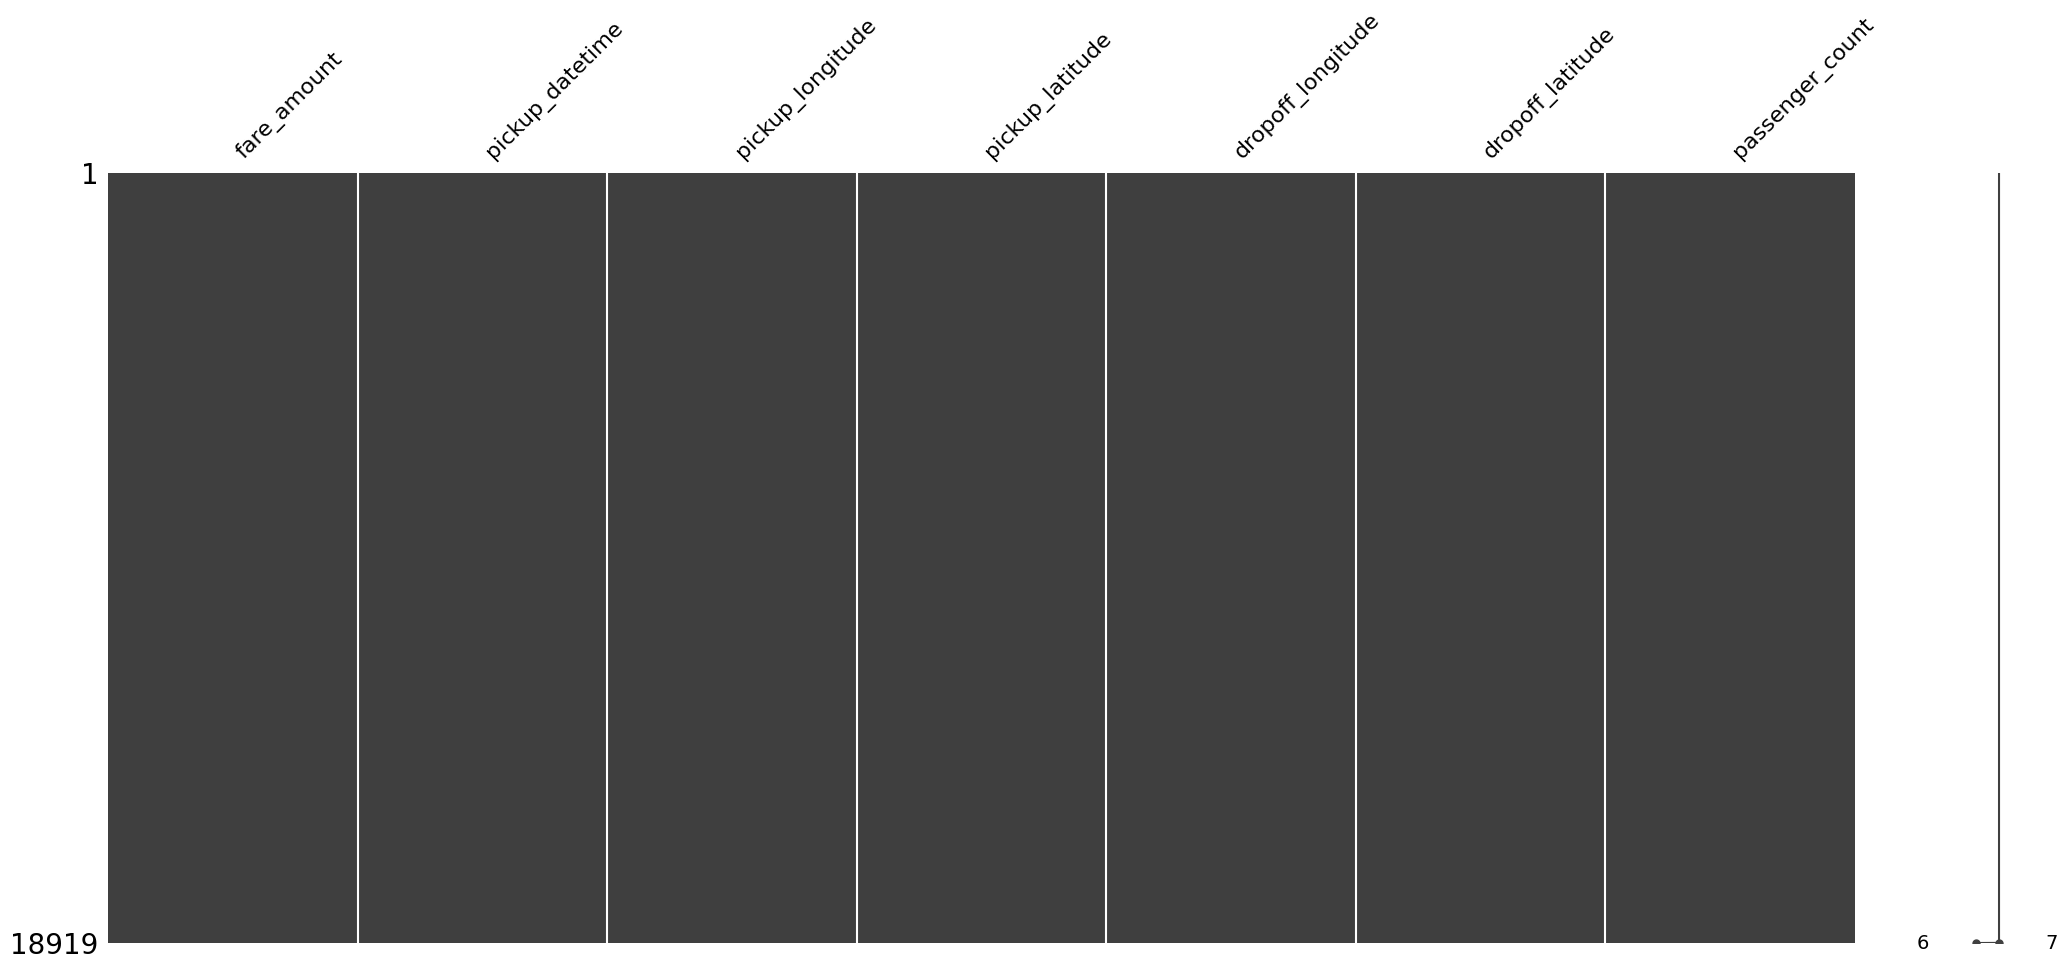

In [2]:
msno.matrix(data)

In [3]:
missing_columns = data.isnull().sum()
print("Jumlah missing di setiap kolom:")
print(missing_columns)

Jumlah missing di setiap kolom:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      1
dtype: int64


In [4]:
data.dropna(inplace=True)

In [5]:
missing_columns = data.isnull().sum()
print("Jumlah missing di setiap kolom:")
print(missing_columns)

Jumlah missing di setiap kolom:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


## **Extract Time Feature**

In [6]:
pickup_dt = data["pickup_datetime"].dt

data['year'] = pickup_dt.year
data['month'] = pickup_dt.month
data['day'] = pickup_dt.dayofweek
data['hour'] = pickup_dt.hour
data.drop(columns='pickup_datetime', inplace=True)
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


## **Extract Distance**

In [7]:
data['distance'] = abs(data['pickup_longitude'] - data['dropoff_longitude']) + abs(data['pickup_latitude'] - data['dropoff_latitude'])
data.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)
data.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


## **SPLITTING**

In [8]:
from sklearn.model_selection import train_test_split

X = data.drop(columns="fare_amount")
y = data["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [ ]:
X_train.columns

Index(['passenger_count', 'year', 'month', 'day', 'hour', 'distance'], dtype='object')

## **Training**

In [9]:
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('yeo_johnson', PowerTransformer(method='yeo-johnson'))
        ]), ['passenger_count', 'year', 'distance']),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), ['month', 'day', 'hour'])
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()),  # Polynomial Features
    ('algo', LinearRegression())  # Model Linear Regression
])

parameter = {
    'algo__fit_intercept': [True, False],
    'poly__degree': [2, 3],
    'poly__interaction_only': [True, False]  # Hanya interaksi antar fitur tanpa suku pangkat
}

In [10]:
model = GridSearchCV(pipeline, param_grid=parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('yeo_johnson',
                                                                                          PowerTransformer())]),
                                                                         ['passenger_count',
                                                                          'year',
                                                                          'distance']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day',
                                                                          'hour'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('algo', LinearRegression())]),
             n_jobs=-1,
             param_grid={'algo__fit_intercept': [True, False],
                         'poly__degree': [2, 3],
                         'poly__interaction_only': [True, False]},
             verbose=1)

In [11]:
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__fit_intercept': False, 'poly__degree': 2, 'poly__interaction_only': False}
0.6814399420832529 0.6418127048648947 0.6745012330874967


## **EVALUASI MODEL**

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"Jumlah data train: {X_train.shape[0]}")
print(f"Jumlah data test: {X_test.shape[0]}\n")

print("**Evaluasi pada Data Train**")
print(f"Train R² Score: {r2_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train MAPE: {mape_train:.2f}%\n")

print("**Evaluasi pada Data Test**")
print(f"Test R² Score: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAPE: {mape_test:.2f}%")

Jumlah data train: 15134
Jumlah data test: 3784

**Evaluasi pada Data Train**
Train R² Score: 0.6814
Train MAE: 2.9294
Train MSE: 29.5406
Train RMSE: 5.4351
Train MAPE: 36.64%

**Evaluasi pada Data Test**
Test R² Score: 0.6745
Test MAE: 2.9615
Test MSE: 27.7320
Test RMSE: 5.2661
Test MAPE: inf%


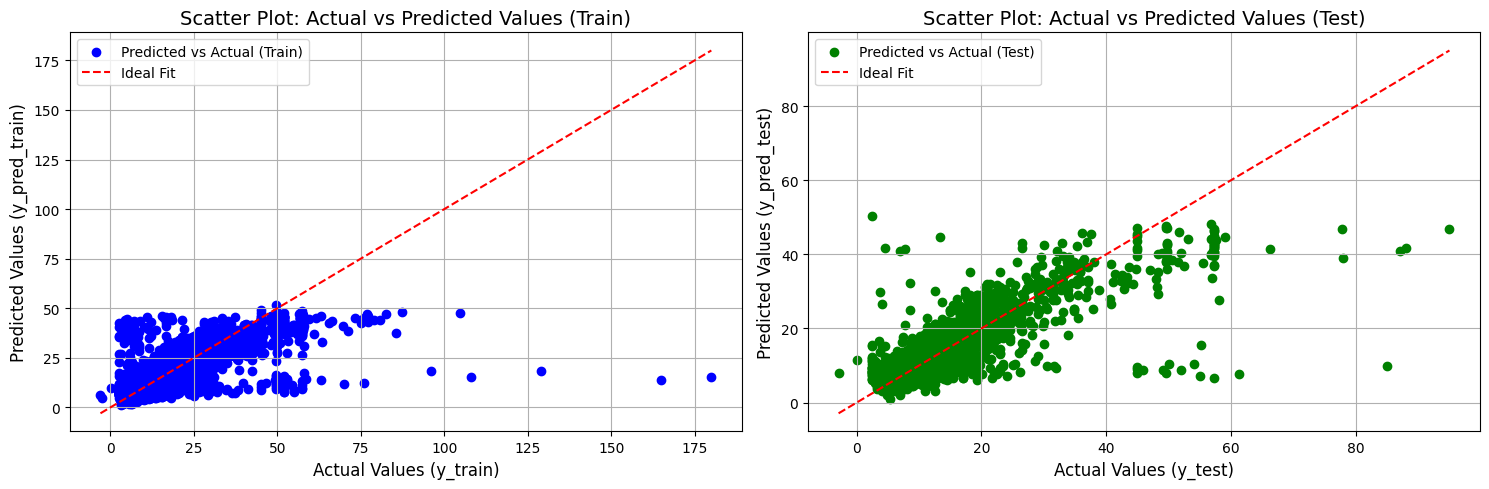

In [13]:
import matplotlib.pyplot as plt

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_train, y_pred_train, color='blue', label='Predicted vs Actual (Train)')
axes[0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Ideal Fit')
axes[0].set_title('Scatter Plot: Actual vs Predicted Values (Train)', fontsize=14)
axes[0].set_xlabel('Actual Values (y_train)', fontsize=12)
axes[0].set_ylabel('Predicted Values (y_pred_train)', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(y_test, y_pred_test, color='green', label='Predicted vs Actual (Test)')
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
axes[1].set_title('Scatter Plot: Actual vs Predicted Values (Test)', fontsize=14)
axes[1].set_xlabel('Actual Values (y_test)', fontsize=12)
axes[1].set_ylabel('Predicted Values (y_pred_test)', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

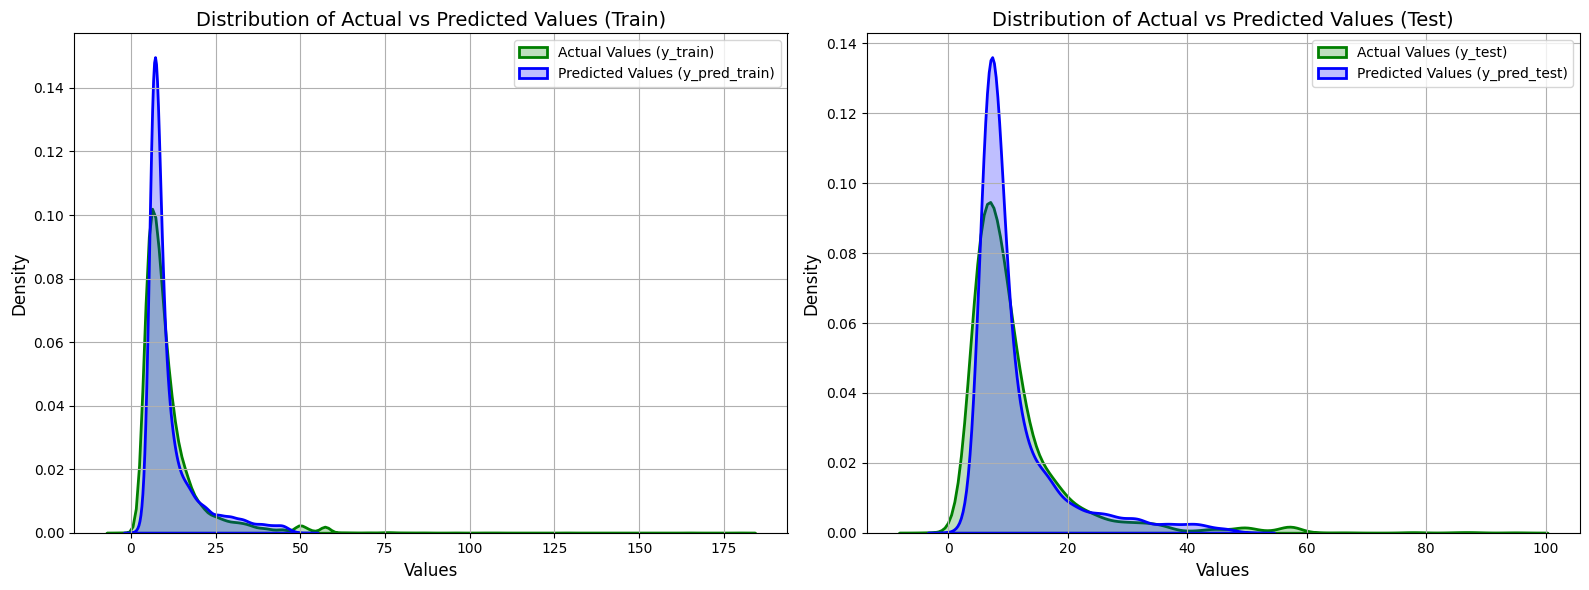

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(y_train, color='green', label='Actual Values (y_train)', fill=True, linewidth=2, ax=axes[0])
sns.kdeplot(y_pred_train, color='blue', label='Predicted Values (y_pred_train)', fill=True, linewidth=2, ax=axes[0])

axes[0].set_title('Distribution of Actual vs Predicted Values (Train)', fontsize=14)
axes[0].set_xlabel('Values', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend()
axes[0].grid(True)

sns.kdeplot(y_test, color='green', label='Actual Values (y_test)', fill=True, linewidth=2, ax=axes[1])
sns.kdeplot(y_pred_test, color='blue', label='Predicted Values (y_pred_test)', fill=True, linewidth=2, ax=axes[1])

axes[1].set_title('Distribution of Actual vs Predicted Values (Test)', fontsize=14)
axes[1].set_xlabel('Values', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

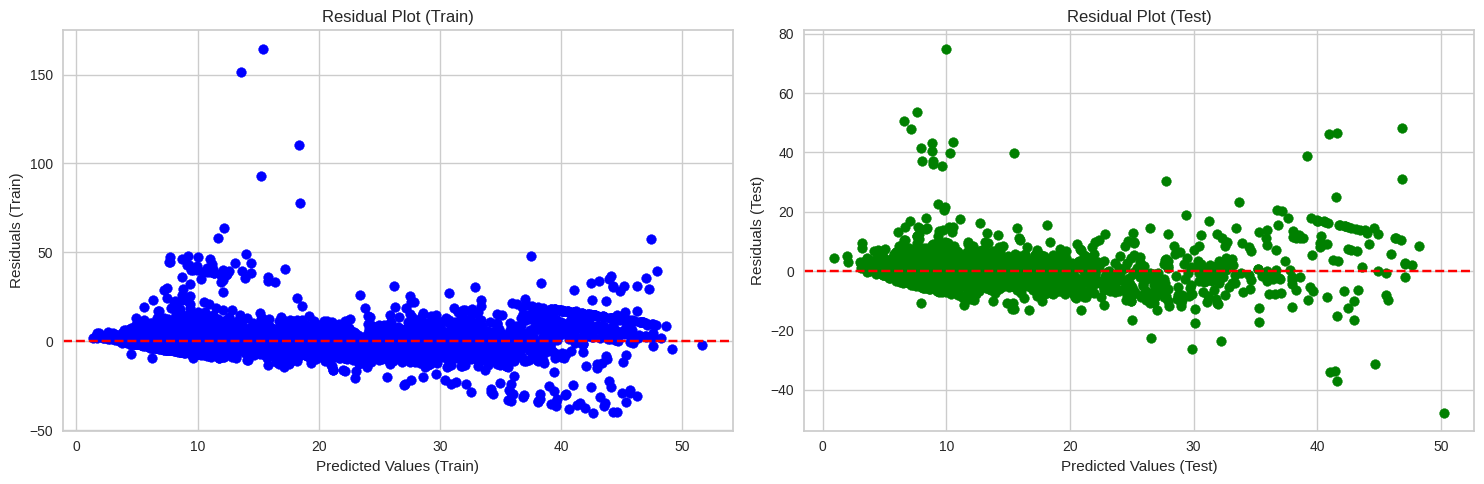

In [17]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_train, residuals_train, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values (Train)")
plt.ylabel("Residuals (Train)")
plt.title("Residual Plot (Train)")

plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, residuals_test, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values (Test)")
plt.ylabel("Residuals (Test)")
plt.title("Residual Plot (Test)")

plt.tight_layout()
plt.show()

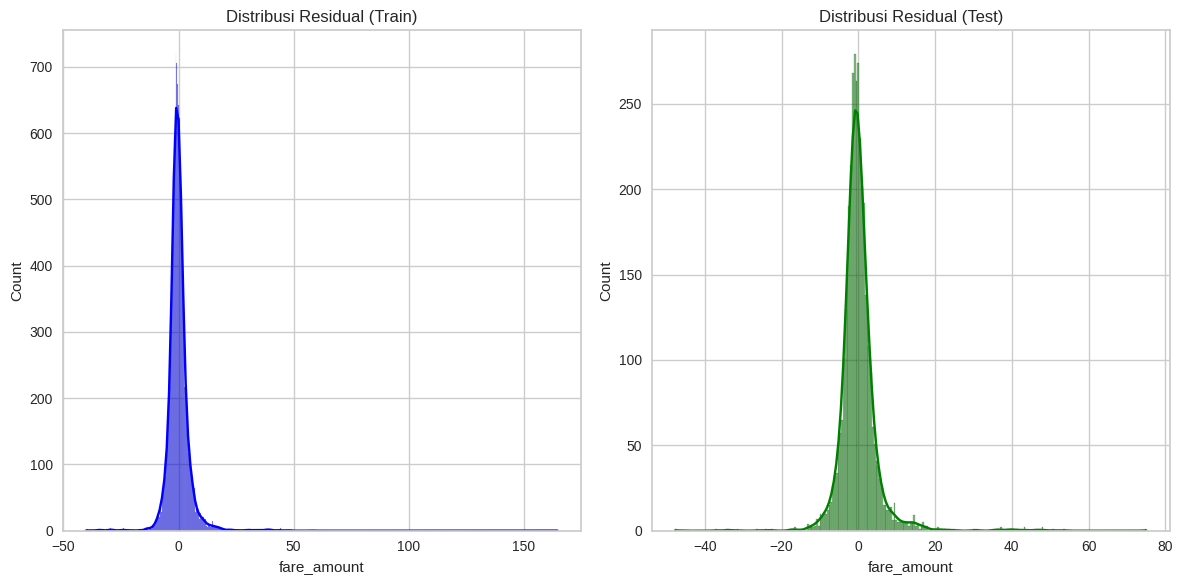

In [18]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals_train, kde=True, color='blue')
plt.title("Distribusi Residual (Train)")

plt.subplot(1, 2, 2)
sns.histplot(residuals_test, kde=True, color='green')
plt.title("Distribusi Residual (Test)")

plt.tight_layout()
plt.show()

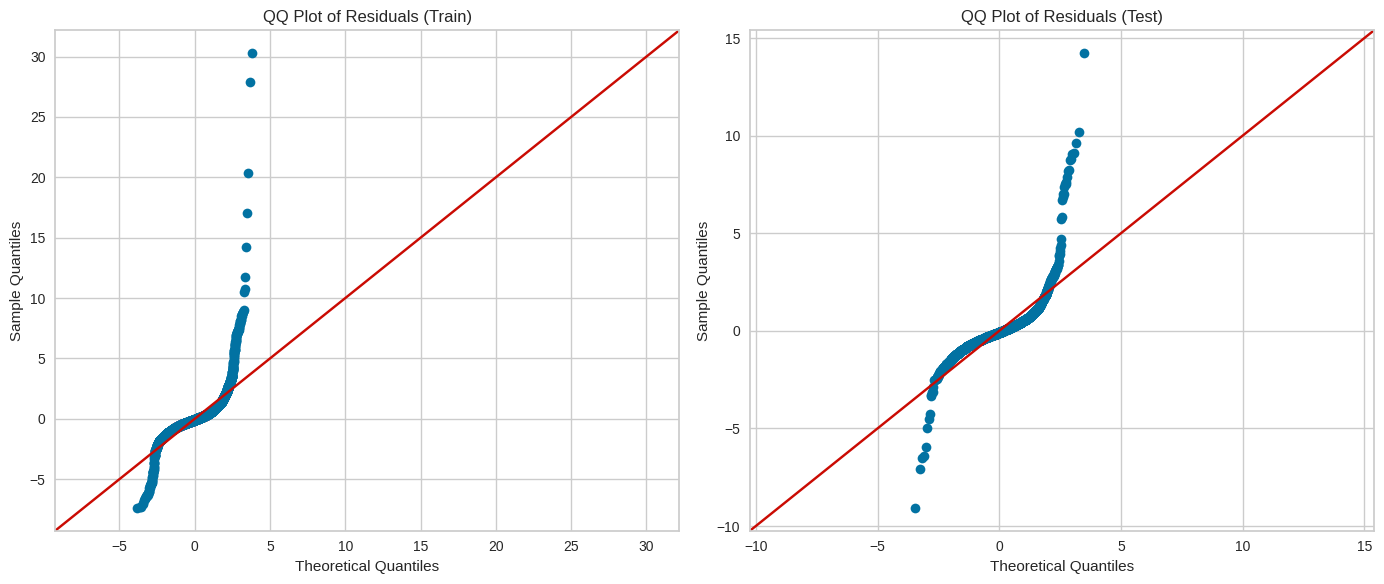

In [19]:
import statsmodels.api as sm

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sm.qqplot(residuals_train, line='45', fit=True, ax=plt.gca())
plt.title("QQ Plot of Residuals (Train)")

plt.subplot(1, 2, 2)
sm.qqplot(residuals_test, line='45', fit=True, ax=plt.gca())
plt.title("QQ Plot of Residuals (Test)")

plt.tight_layout()
plt.show()

## **SAVE MODEL**

In [20]:
import pickle

best_pipeline = model.best_estimator_
with open("taxifare.pkl", "wb") as file:
    pickle.dump(best_pipeline, file)

## **LOAD MODEL DAN PREDICT**

In [22]:
import pickle

with open("taxifare.pkl", "rb") as file:
    loaded_model = pickle.load(file)

## Prediksi

In [23]:
X_train.iloc[1]

,578
passenger_count,3.000000
year,2010.000000
month,3.000000
day,3.000000
hour,10.000000
distance,0.009293


In [25]:
new_data = pd.DataFrame({
    'passenger_count': [2.0],
    'year': [2015.0],
    'month': [12.0],
    'day': [25.0],
    'hour': [18.0],
    'distance': [5.3]
})

new_data['Predict'] = loaded_model.predict(new_data)
new_data

,passenger_count,year,month,day,hour,distance,Predict
0,2.0,2015.0,12.0,25.0,18.0,5.3,44.480073
